In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sl

import seaborn as sns; sns.set()
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
%matplotlib inline

# Tarea 3: Encuentre la regresión

Ud recibe unos datos $x$ y $y$ cómo se muestran a continuación. Ud debe responder cuatro preguntas a partir de estos datos. Suponga que ud tiene un modelo tal que $y=f(x)$ más aún desconoce $f$.

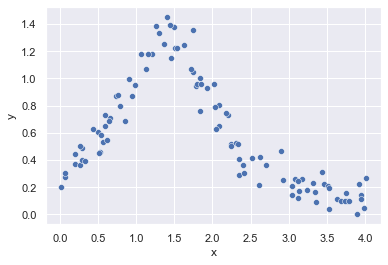

,x,y
0,0.065859,0.277413
1,0.020931,0.202239
2,0.070312,0.307369
3,0.206166,0.367530
4,0.286572,0.491144
...,...,...
95,3.922613,0.225565
96,3.898473,0.000000
97,3.952111,0.141005
98,3.939211,0.115500


In [2]:
df = pd.read_pickle('ex1.gz')
sns.scatterplot(x='x',y='y',data=df)
plt.show()
df

## (A) Pendiente e intercepto
Determine la pendiente de los datos en el intervalo $[0,1.5]$ y el valor del intercepto con el eje $y$. Es decir, $f(0)=?$. ¿Cuál es el valor de $r^2$?

In [3]:
df_filtrado = df.loc[df['x']<=1.5, :]
# insertamos una columna de unos para calcular el intercepto
df_filtrado.insert(0, 'x0', 1)

In [4]:
# Método SciPy
#   ver -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
sol_3a = sp.stats.linregress(x=df_filtrado['x'], y=df_filtrado['y'])
print(f'Pendiente: {sol_3a.slope:.8f}')
print(f'Intercepto: {sol_3a.intercept:.8f}')
print(f'r^2: {sol_3a.rvalue**2:.6f}')

Pendiente: 0.81638696
Intercepto: 0.18270691
r^2: 0.931642


In [5]:
# calle 110 no 9 25 piso 5 oficina 512: jimmy guerrero
# Método Matricial: Sistemas Lineales de la clase
# => Vamos a crear una funcion que hace la regresion -> nos simplifica la vida
def regresion_lineal(data):
    assert isinstance(data, pd.DataFrame), 'FEATURE MISSING: `data` must be a Pandas Dataframe'
    _data = data.copy()
    _cols = list(map(lambda x: ''.join(str(x).split()).lower(), data.columns))
    assert 'y' in _cols, 'ERROR: \'y\' not in the columns'
    _data.columns = _cols

    # creamos las matrices X y Y: X*beta = Y
    _Y = np.matrix(_data.loc[:, ['y']].to_numpy(dtype=np.float64))
    _cols.pop(_cols.index('y'))
    _X = np.matrix(_data.loc[:, _cols].to_numpy(dtype=np.float64))

    # calculamos beta estimado
    _beta = np.linalg.inv(_X.T*_X)*_X.T*_Y

    # calculamos las predicciones estimadas y "reescribimos" observaciones
    _Y_pred = np.array(_X*_beta).flatten()
    _Y_obs = np.array(_Y).flatten()
    _Y_barra = _Y_obs.mean()
    _r2 = 1-(np.linalg.norm(_Y_pred - _Y_obs)**2)/(np.linalg.norm(_Y_obs - _Y_barra)**2)

    # organizamos el diccionario que vamos a retornar
    _X = np.array(_X)
    _X = _X.flatten() if 1 in _X.shape else _X
    _beta = np.array(_beta).flatten()
    _resultado = dict(zip(_cols, _beta), **{
        'y_pred': _Y_pred, 'r2': _r2,
        'beta': _beta, 'vars': _cols
    })
    return _resultado

Pendiente: 0.81638696
Intercepto: 0.18270691
r^2: 0.931642


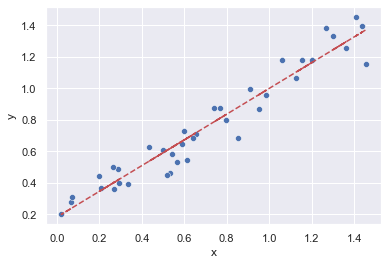

In [6]:
sol_3a_alt = regresion_lineal(df_filtrado)
print(f'Pendiente: {sol_3a_alt["x"]:.8f}')
print(f'Intercepto: {sol_3a_alt["x0"]:.8f}')
print(f'r^2: {sol_3a_alt["r2"]:.6f}')

sns.scatterplot(x='x', y='y', data=df_filtrado)
plt.plot(df_filtrado['x'], sol_3a_alt['y_pred'], 'r--')
plt.show()

## (B) Regresión polinomial
Suponga que quiere realizar la siguiente regresión polinomial,
$$y=\beta_1+\beta_2x+\beta_2x^2+\beta_2x^3+\beta_2x^4+\beta_2x^5.$$
Plantee la función de costo que le permita calcular los coeficientes y calcule $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$, y $\beta_5$. ¿Cuál es el $r^2$?

Calcule $f(0)$ y compare con los resultados anteriores

In [7]:
# => Vamos a crear una funcion que prepara los datos polinomiales -> nos simplifica la vida
def preparar_datos(data, /, poly=1):
    assert isinstance(data, pd.DataFrame), 'FEATURE MISSING: `data` must be a Pandas Dataframe'
    _data = data.copy()
    _cols = list(map(lambda x: ''.join(str(x).split()).lower(), data.columns))
    assert 'y' in _cols, 'ERROR: \'y\' not in the columns'
    _data.columns = _cols
    _cols.pop(_cols.index('y'))
    assert isinstance(poly, int) and poly>0

    # 1. funciones auxiliares que me dan el nombre y los valores de la columna
    # nombre_columna = lambda _cs, _n: '*'.join(((_cs+' ')*_n).split())
    nombre_columna = lambda _cs, _n: str(_cs)+'^'+str(_n)
    datos_columna = lambda _dc, _n: np.power(_dc, _n)
    # 2. Agregar los terminos polinomiales columna a columna (no hace las combinaciones)
    #    NOTA: si queremos las combinaciones, tenemos que usar `itertools`
    #          https://docs.python.org/3/library/itertools.html#itertools.combinations_with_replacement
    _data.insert(0, '_intercepto', 1)
    _new_data = _data.loc[:, ['_intercepto', 'y']]
    for _c in reversed(_cols):
        for _p in range(poly, 0, -1):
            _new_data.insert(
                1,
                nombre_columna(_c, _p),
                datos_columna(_data[_c].values, _p)
            )
    return _new_data

In [8]:
# => Vamos a crear una funcion de costo que me toma los datos en formato DataFrame y una funcion
#    NOTA: esa funcion puede ser por ejemplo la sigmoidal
def FuncCosto(beta, data, func):
    Y = data['y'].values
    deltaY = func(x=data, params=beta) - Y
    # vamos a usar el estimador de distancia cuadratica media
    return np.dot(deltaY, deltaY)/len(deltaY)

In [9]:
# => Escribo las funciones
def func_linear(x, params):
    X = x.loc[:, x.columns != 'y'].values
    return np.dot(X, params)
##### dejo como ejemplo la funcion sigmoidal, pero vamos a usar la lineal
def func_sigmoidal(x, params):
    X = x.loc[:, x.columns != 'y'].values
    return 1/(1+np.exp(-np.dot(X, params)))

In [10]:
new_df = preparar_datos(df, poly=5)
new_df

,_intercepto,x^1,x^2,x^3,x^4,x^5,y
0,1,0.065859,0.004337,0.000286,1.881288e-05,1.238994e-06,0.277413
1,1,0.020931,0.000438,0.000009,1.919277e-07,4.017187e-09,0.202239
2,1,0.070312,0.004944,0.000348,2.444111e-05,1.718506e-06,0.307369
3,1,0.206166,0.042504,0.008763,1.806610e-03,3.724609e-04,0.367530
4,1,0.286572,0.082123,0.023534,6.744268e-03,1.932718e-03,0.491144
...,...,...,...,...,...,...,...
95,1,3.922613,15.386893,60.356824,2.367565e+02,9.287040e+02,0.225565
96,1,3.898473,15.198094,59.249365,2.309821e+02,9.004774e+02,0.000000
97,1,3.952111,15.619183,61.728750,2.439589e+02,9.641527e+02,0.141005
98,1,3.939211,15.517382,61.126237,2.407891e+02,9.485192e+02,0.115500


In [11]:
sol_3b = sp.optimize.minimize(
    fun=FuncCosto,
    x0=np.zeros(new_df.shape[1]-1),
    args = (new_df, func_linear),
    tol=1e-10
)
sol_3b

      fun: 0.012550627021287898
 hess_inv: array([[ 1.16611506e+01, -3.92307241e+01,  4.20370156e+01,
        -1.95727511e+01,  4.13406862e+00, -3.24988669e-01],
       [-3.92307241e+01,  2.02730035e+02, -2.85685270e+02,
         1.63981529e+02, -4.11721089e+01,  3.75897229e+00],
       [ 4.20370156e+01, -2.85685270e+02,  4.73552974e+02,
        -3.01719262e+02,  8.14335278e+01, -7.83978287e+00],
       [-1.95727511e+01,  1.63981529e+02, -3.01719262e+02,
         2.04515430e+02, -5.75182572e+01,  5.70350145e+00],
       [ 4.13406862e+00, -4.11721089e+01,  8.14335278e+01,
        -5.75182572e+01,  1.66259118e+01, -1.68182732e+00],
       [-3.24988669e-01,  3.75897229e+00, -7.83978287e+00,
         5.70350145e+00, -1.68182732e+00,  1.72668284e-01]])
      jac: array([-1.44354999e-08, -1.09430403e-08, -3.69036570e-08, -6.61239028e-08,
       -6.60074875e-08,  4.56348062e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 325
      nit: 32
     njev:

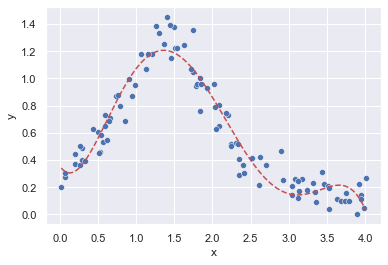

In [12]:
# graficamos:
X_graph = pd.DataFrame({
    'x': np.linspace(df['x'].min(), df['x'].max(), 1000),
    'y': 0
})
X_graph['y'] = func_linear(
    x=preparar_datos(X_graph, poly=5),
    params=sol_3b['x']
)
sns.scatterplot(x='x', y='y', data=df)
plt.plot(X_graph['x'], X_graph['y'], 'r--')
plt.show()

## (C) Regresión polinomial exacta
Resulta, que cuando se quiere hacer alguna regresión polinomial esta se puede hacer de forma exacta. ¿Cómo? Suponga que ud va a considerar que su problema en lugar de tener $1$ variable ($x$) tiene $n+1$, siendo $n$ el orden del polinomio a ajustar. Es decir, sus nuevas variables van a ser $\{x_0,\,x_1,\,x_2,\,x_3,\dots,\,x_n\}$ definiendo $x_j=x^j$. Así pues, siguiendo el mismo procedimiento para la regresión lineal multidimensional que realizamos para el ejercicio de datos inmobiliarios, puede encontrar los valores de los coeficientes $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$, y $\beta_5$. Encuentre estos valores y compare con los resultados en la sección **(B)**.

Calcule $f(0)$ y compare con los resultados anteriores.

> Si ud se pregunta si esto es posible la respuesta es sí. Inclusive, esto se puede extender a cualquier a cualquier conjunto de funciones, tal que $x_j=f_j(x)$, que represente un conjunto "linealmente independiente" (¡Me estoy adelantando a *Fourier*!). Para quienes quieran explorar algunas curiosidades matemáticas, cuando $n+1$ es igual al número de puntos o valores de $x$ (y todos diferentes) la matriz es siempre invertible y resulta ser la inversa de una matriz de Vandermonde.

In [13]:
# Siendo que hicimos muchas cosas anteriormente, todo va a ser mucho mas facil ahora...
# 1. datos preparados
new_df = preparar_datos(df, poly=5)
# 2. hacemos la "regresion lineal" exacta
sol_3c = regresion_lineal(new_df)
# elimino, porque sobran, `graf X` y `graf Y`
sol_3c.pop('graf X', None)
sol_3c.pop('graf Y', None)

print(f'Variables: {sol_3c["vars"]}')
print(f'    Pesos: {sol_3c["beta"]}')
print(f'r^2: {sol_3c["r2"]:.6f}')

Variables: ['_intercepto', 'x^1', 'x^2', 'x^3', 'x^4', 'x^5']
    Pesos: [ 0.35644668 -0.83588268  3.77276401 -2.99526012  0.85614705 -0.08282854]
r^2: 0.919923


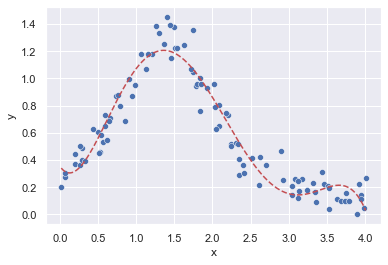

In [14]:
# ahora graficamos...
# graficamos:
X_graph = pd.DataFrame({
    'x': np.linspace(df['x'].min(), df['x'].max(), 1000),
    'y': 0
})
X_graph['y'] = func_linear(
    x=preparar_datos(X_graph, poly=5),
    params=sol_3c['beta']
)
sns.scatterplot(x='x', y='y', data=df)
plt.plot(X_graph['x'], X_graph['y'], 'r--')
plt.show()

## (D) Regresión a un modelo teórico

Suponga que su modelo teórico es el siguiente:
$$y=\frac{a}{\left[(x-b)^2+c\right]^\gamma}.$$
Halle $a$, $b$, $c$ y $\gamma$.

Calcule $f(0)$ y compare con los resultados anteriores

In [15]:
# Siendo que hicimos muchas cosas anteriormente, todo va a ser mucho mas facil ahora...
# lo único que tengo que hacer es escribir una funcion especial y hacer minimizacion/optimizacion

# => Escribo las funciones
def func_especial(x, params):
    a, b, c, gamma = params
    X = x['x'].values
    return a/np.power((X-b)**2+c, gamma)
# => Hago la optimizacion
sol_3d = sp.optimize.minimize(
    fun=FuncCosto,
    x0=np.array([0,0,0,1]), ## a, b, c, gamma
    args = (df, func_especial),
    tol=1e-10
)
sol_3d

      fun: 0.008230571431452201
 hess_inv: array([[3.78825269e+01, 3.49485254e-02, 5.01839900e+01, 4.86673821e+01],
       [3.49485254e-02, 1.09903356e+00, 1.24913657e-01, 1.19525422e-01],
       [5.01839900e+01, 1.24913657e-01, 6.78966389e+01, 6.76237924e+01],
       [4.86673821e+01, 1.19525422e-01, 6.76237924e+01, 7.30205891e+01]])
      jac: array([-9.31322575e-09,  3.43425199e-08, -3.95812094e-09,  1.73458830e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 531
      nit: 64
     njev: 104
   status: 2
  success: False
        x: array([0.68740928, 1.39239356, 0.49566069, 0.93665744])

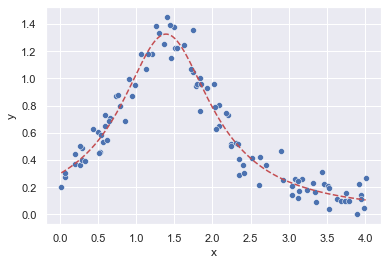

In [16]:
# ahora graficamos...
# graficamos:
X_graph = pd.DataFrame({'x': np.linspace(df['x'].min(), df['x'].max(), 1000)})
X_graph['y'] = func_especial(x=X_graph, params=sol_3d['x'])
sns.scatterplot(x='x', y='y', data=df)
plt.plot(X_graph['x'], X_graph['y'], 'r--')
plt.show()

# Tarea 4

Con base a los métodos vistos en clase resuelva las siguientes dos preguntas

## (A) Integrales

* $\int_{0}^{1}x^{-1/2}\,\text{d}x$
* $\int_{0}^{\infty}e^{-x}\ln{x}\,\text{d}x$
* $\int_{0}^{\infty}\frac{\sin{x}}{x}\,\text{d}x$

In [17]:
### pueden usar cuadraturas si quieren!
# -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.roots_chebyt.html
# para la primera recordemos que debemos tomar un epsilon mayor a cero muy pequeño
epsilon = 1e-6
# vamos a tomar el intervalo entre 0 y 1 no uniforme tal que distancia entre uno y otro disminuya a medida q nos acercamos a 0
alpha = 5/2 # es una potencia muy conveniente que me define como decrece dx vs la altura y vs el area. Mantiene el error bajito
N = int(1/(epsilon**(1/alpha))) + 1 # numero de puntos queda determinado por epsilon
print(f'N={N}')
x = np.linspace(0, 1, N)**alpha
y = np.power(x, -1/2)
y[0] = np.power(x[1]/2, -1/2)
print('Integral exacta: 2')
print('Integral:',sp.integrate.simpson(y, x))

N=252
Integral exacta: 2
Integral: 1.998680199299693


/var/folders/g0/1krznd0j4xq2w7hp515svkb80000gp/T/ipykernel_34866/4032162835.py:10: RuntimeWarning: divide by zero encountered in power
  y = np.power(x, -1/2)


In [18]:
# para la segunda... usamos los polinomios generalizados de laguerre
N = 10
z, w = sp.special.roots_genlaguerre(n=N, alpha=0)
def f(x):
    return np.log(x)
print('Valor exacto: -Euler Mascheroni=-0.577215664901...')
print('Integral:', np.dot(f(z), w))

Valor exacto: -Euler Mascheroni=-0.577215664901...
Integral: -0.5147180612524798


### -> Sin embargo, uno puede mejorar esta integral con una integral por partes
$$
\begin{eqnarray*}
\int_{0}^{\infty}e^{-x}\ln{x}\,\text{d}x = \overbrace{\left(x\ln{x}-x\right)e^{-x}\Big\vert_{0}^{\infty}}^{\text{cancels}}+\int_{0}^{\infty}\left(x\ln{x}-x\right)e^{-x}\,\text{d}x = \int_{0}^{\infty}\left(x\ln{x}-x\right)e^{-x}\,\text{d}x
\end{eqnarray*}
$$

In [19]:
def f1(x):
    return x*(np.log(x)-1)
print('Integral:', np.dot(f1(z), w))

Integral: -0.5798107635615206


y si hago ooootra integración por partes...
$$
\int_{0}^{\infty}e^{-x}\ln{x}\,\text{d}x = \overbrace{\left(\frac{x^2}{2}\ln{x}-\frac{3}{4}x^2\right)e^{-x}\Big\vert_{0}^{\infty}}^{\text{cancels}}+\int_{0}^{\infty}\left(\frac{x^2}{2}\ln{x}-\frac{3}{4}x^2\right)e^{-x}\,\text{d}x = \int_{0}^{\infty}\left(\frac{x^2}{2}\ln{x}-\frac{3}{4}x^2\right)e^{-x}\,\text{d}x
$$

In [20]:
def f2(x):
    return 0.5*(x**2)*(np.log(x)-1.5)
print('Integral:', np.dot(f2(z), w))

Integral: -0.5770278608837813


In [21]:
# por ultimo, la de sinc(x) o sin(x)/x, tomemos los periodos de 2pi, y como es una funcion suave se puede usar simpson o trapecio
# pero... hay que mirar lo asintotico... aqui es mas importante ver lo asintotico

In [22]:
import math
x_periodo = np.linspace(0,2*np.pi,20)
x0 = lambda j:2*np.pi*j # donde j es el trozo de periodicidad 2pi que estamos analizando
def sinc(x):
    _sinc = lambda y: math.sin(y)/y if y!=0 else 1
    return np.array(list(map(_sinc, x)))

In [23]:
# Podemos usar simpson para integrar en cada periodo la contribución a la integral
Nj = 10 # vamos a integrar 10 periodos
sum_integral = 0
for j in range(Nj):
    x = x0(j) + x_periodo
    sum_integral += sp.integrate.simpson(sinc(x), x)
print('Valor exacto: pi/2 = 1.570796326794...')
print('Integral:',sum_integral)

Valor exacto: pi/2 = 1.570796326794...
Integral: 1.5541601970945513


In [24]:
# si queremos ver como se aproxima, veamos, tomemos Nj como si fuera una secuencia de fibonacci (por que? se los dejo a uds)
def fib(n):
    _f = []
    for _n in range(n):
        if _n <= 1:
            _f.append(1)
        else:
            _f.append(_f[-2]+_f[-1])
    return _f.copy()
Nj = fib(26)[1:]
partial_sum = []
for nj in Nj: #-> se puede optimizar y se los dejo a uds!
    sum_integral = 0
    print('progreso:', nj)
    for j in range(nj):
        x = x0(j) + x_periodo
        sum_integral += sp.integrate.simpson(sinc(x), x)
    partial_sum.append(sum_integral)

progreso: 1
progreso: 2
progreso: 3
progreso: 5
progreso: 8
progreso: 13
progreso: 21
progreso: 34
progreso: 55
progreso: 89
progreso: 144
progreso: 233
progreso: 377
progreso: 610
progreso: 987
progreso: 1597
progreso: 2584
progreso: 4181
progreso: 6765
progreso: 10946
progreso: 17711
progreso: 28657
progreso: 46368
progreso: 75025
progreso: 121393


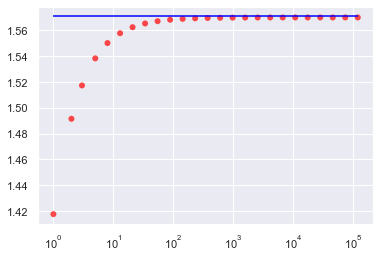

In [25]:
plt.hlines(np.pi/2, min(Nj), max(Nj), 'blue')
ax = plt.gca()
ax.scatter(Nj ,partial_sum , c='red', alpha=0.7, edgecolors='none')
ax.set_xscale('log')

## (B) Fourier

Calcule la transformada rápida de Fourier para la función de la **Tarea 3 (D)** en el intervalo $[0,4]$ ($k$ máximo $2\pi n/L$ para $n=25$). Ajuste la transformada de Fourier para los datos de la **Tarea 3** usando el método de regresión exacto de la **Tarea 3 (C)** y compare con el anterior resultado. Para ambos ejercicios haga una interpolación y grafique para comparar.

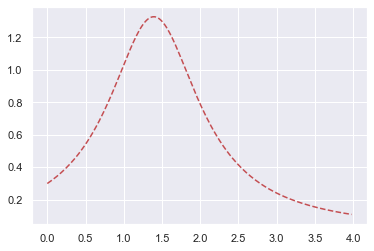

In [26]:
# literalmente tomen el ejemplo de scipy: https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html#d-discrete-fourier-transforms
# o... usen las funciones que hicimos en clase
from scipy.fft import fft, rfft, fftfreq

N = 200
x = np.linspace(0, 4, N, endpoint=False)
dx = 4/N
y = func_especial(x=pd.DataFrame({'x': x}), params=sol_3d.x)
plt.plot(x, y, 'r--')

In [27]:
# aplicamos la de la clase
def FFT(x, y, a, L, /, Nf=None):
    detNf = lambda n: (n+1)//2 if n%2==1 else n//2
    Nf = detNf(len(x)) if Nf is None else Nf
    assert all(x>=a) and all(x<a+L), f'`x` fuera del interfalo [{a}, {a+L})'
    k = lambda j: 2*j*np.pi/L
    def a_j(j):
        new_y = y*np.cos(k(j)*x)/L
        if j > 0:
            new_y = new_y * 2
        return sp.integrate.simpson(new_y, x)
    def b_j(j):
        new_y = y*np.sin(k(j)*x)/L
        if j > 0:
            new_y = new_y * 2
        return sp.integrate.simpson(new_y, x)

    Aj = np.array([a_j(j) for j in range(Nf)])
    Bj = np.array([b_j(j) for j in range(Nf)])
    Cj = np.array([(Aj[j]-Bj[j]*1J)*(0.5 if j>0 else 1) for j in range(Nf)])
    return {
        'Nf': Nf, 'a': a, 'L': L,
        'Aj': Aj, 'Bj': Bj, 'Cj': Cj
    }
def invFFT(fft, /, x=None, frec=0, N=None):
    # fft is the output of FFT
    Nf=fft['Nf']
    a=fft['a']
    L=fft['L']
    Aj=fft['Aj']
    Bj=fft['Bj']

    if N is not None:
        Nf = min(N,Nf)
    x_tilde = np.linspace(
            a-frec*L,
            a+(frec+1)*L,
            1000*(2*frec+1),
            endpoint=False
        ) if x is None else x.copy()
    k = lambda j: 2*j*np.pi/L
    y_tilde = np.sum([
        Aj[j] * np.cos(k(j)*x_tilde) + Bj[j] * np.sin(k(j)*x_tilde) for j in range(Nf)
    ], axis=0)
    return x_tilde, y_tilde

In [28]:
sol_4b_1 = FFT(x, y, 0, 4)

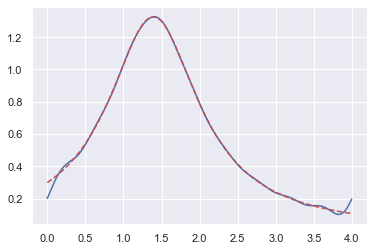

In [29]:
graf_x, graf_y = invFFT(sol_4b_1, frec=0, N=10)
plt.plot(graf_x, graf_y, 'b-')
plt.plot(x, y, 'r--')

In [30]:
# usando SciPy -> para comparar!
yf = rfft(y)/N
yf[:10]

array([ 5.85665088e-01+0.j        , -1.60141634e-01-0.21278554j,
       -3.28218798e-02+0.05867375j,  2.00759871e-02-0.01607984j,
       -8.09432819e-03-0.01224763j, -1.20738978e-03-0.00329195j,
        1.28431840e-04-0.00540892j, -5.75788528e-04-0.00437902j,
       -1.14342799e-04-0.00365715j,  1.26390718e-05-0.00335742j])

In [31]:
# Fijense que a pesar de lo parecidos, hay diferencias... a que creen uds que se debe?
sol_4b_1['Cj'][:10]

array([ 0.58465078+0.j        , -0.16115594-0.21279659j,
       -0.03383618+0.05865166j,  0.0190617 -0.01611297j,
       -0.00910859-0.01229179j, -0.00222162-0.00334713j,
       -0.00088575-0.00547511j, -0.00158991-0.0044562j ,
       -0.00112838-0.00374531j, -0.0010013 -0.00345652j])

### Por ultimo, para la "regresion" tenemos que hacer un ligero ajuste en una sola funcion
Repitamos 3c

In [32]:
# => Vamos a crear una funcion que prepara los datos polinomiales -> nos simplifica la vida
def preparar_datos_fourier(data, a, L, /, Nf=None):
    assert isinstance(data, pd.DataFrame), 'FEATURE MISSING: `data` must be a Pandas Dataframe'
    _data = data.copy()
    _cols = list(map(lambda x: ''.join(str(x).split()).lower(), data.columns))
    _data.columns = _cols
    assert {'x', 'y'}.issubset(set(_cols)), 'ERROR: \'x\' or \'y\' not in the columns'

    assert L > 0, 'ERROR: `L` must be a nonzero distance'

    # 1. la funcion que me calcula el numero de onda
    k = lambda j: 2*j*np.pi/L
    # 2. funciones auxiliares que dan el valor de la columna
    def a_j(j, x):
        return np.cos(k(j)*x)
    def b_j(j, x):
        return np.sin(k(j)*x)
    # 3. Agregar los terminos polinomiales columna a columna (no hace las combinaciones)
    #    NOTA: si queremos las combinaciones, tenemos que usar `itertools`
    #          https://docs.python.org/3/library/itertools.html#itertools.combinations_with_replacement
    _data.insert(0, 'A_0', 1)
    _x = _data['x'].values
    _new_data = _data.loc[:, ['A_0', 'y']]
    for _p in range(Nf, 0, -1):
        _new_data.insert(1, 'B_'+str(_p), b_j(_p, _x))
        _new_data.insert(1, 'A_'+str(_p), a_j(_p, _x))
    return _new_data

In [33]:
# Siendo que hicimos muchas cosas anteriormente, todo va a ser mucho mas facil ahora...
# 1. datos preparados
new_df = preparar_datos_fourier(df, 0, 4, Nf=6)
# 2. hacemos la "regresion lineal" exacta
sol_4b_2 = regresion_lineal(new_df)
# elimino, porque sobran, `graf X` y `graf Y`
sol_4b_2.pop('graf X', None)
sol_4b_2.pop('graf Y', None)

from pprint import pformat
Aj_seleccion = list(map(lambda s: s.startswith('a_'), sol_4b_2['vars']))
Aj = sol_4b_2["beta"][Aj_seleccion]
Bj_seleccion = list(map(lambda s: s.startswith('b_'), sol_4b_2['vars']))
Bj = sol_4b_2["beta"][Bj_seleccion]
print(f'Aj (integracion): {sol_4b_1["Aj"][:10]}')
print(f'Aj (regresion): {Aj}')
print(f'Bj (integracion): {sol_4b_1["Bj"][:10]}')
print(f'Bj (regresion): {Bj}')
print(f'r^2: {sol_4b_2["r2"]:.6f}')

Aj (integracion): [ 0.58465078 -0.32231188 -0.06767236  0.03812341 -0.01821718 -0.00444323
 -0.0017715  -0.00317982 -0.00225676 -0.0020026 ]
Aj (regresion): [ 0.58618461 -0.32035709 -0.07217405  0.0269929  -0.00946633 -0.02875748
  0.01316534]
Bj (integracion): [ 0.          0.42559317 -0.11730333  0.03222594  0.02458358  0.00669426
  0.01095022  0.0089124   0.00749061  0.00691305]
Bj (regresion): [ 0.42171768 -0.1189321   0.05393187  0.01523528 -0.00159776  0.03960902]
r^2: 0.955239


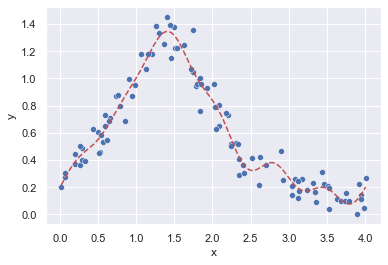

In [34]:
# ahora graficamos...
# graficamos:
X_graph = pd.DataFrame({
    'x': np.linspace(df['x'].min(), df['x'].max(), 1000),
    'y': 0
})
X_graph['y'] = func_linear(
    x=preparar_datos_fourier(X_graph, 0, 4, Nf=6),
    params=sol_4b_2['beta']
)
sns.scatterplot(x='x', y='y', data=df)
plt.plot(X_graph['x'], X_graph['y'], 'r--')
plt.show()